# Resumo da Aula de Validação de Modelos

In [0]:
!pip install graphviz==0.9
!pip install pydot
!pip install seaborn==0.9.0

!apt-get install grapviz

  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package grapviz


In [0]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [0]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


In [0]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [0]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [0]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [0]:
# GroupKFold em um pipeline com StandardScaler e SVC
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


# Plotando uma Árvore de Decisão

In [0]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)  # A profundidade máxima de uma árvore é um Hiperparâmetro
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


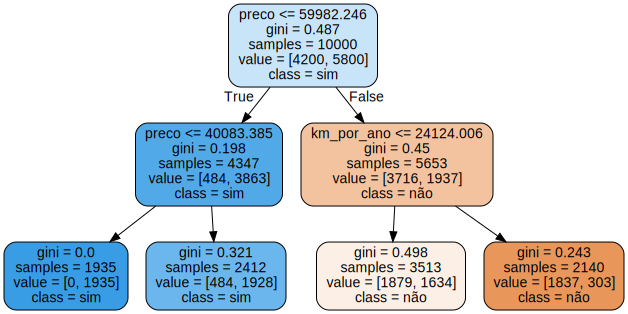

In [0]:
from sklearn.tree import export_graphviz
import graphviz

# Na validação cruzada, nós treinamos o algoritmo 10 vezes para termos uma estimativa de quão bem esse modelo funcionaria no mundo real. 
# Agora queremos o modelo propriamente dito para utilizarmos na vida real.
modelo.fit(x_azar,y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

# Parâmetros que são definidos antes do treino são chamados de HIPERPARÂMETROS, 
# e são diferentes de valores internos do modelo que vão sendo alterados de acordo com o que o modelo está aprendendo.

# Testando Hiperparâmetros - 1 Dimensão
  **Profundidade Máxima da Árvore**

In [0]:
# função para rodar diversos tamanhos de arvores

def roda_arvore_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = max_depth) 
  
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)  # habilitar para retornar os resultados do treino
  
  resultado_treino = results['train_score'].mean() * 100  
  resultado_teste  = results['test_score'].mean() * 100
  print('Árvore max_depth: %d - Média Treino: %.2f - Média Teste: %.2f' % (max_depth, resultado_treino, resultado_teste))
  tabela = [max_depth, resultado_treino, resultado_teste]
  return tabela
  
resultados = [roda_arvore_decisao(i) for i in range (1, 25)]  # faz um loop para chamar a função i vezes, e retornar uma lista com a tabela
resultados = pd.DataFrame(resultados, columns = ['Max_Depth','Treino','Teste'])  # transforma os resultados em um DF
resultados.head()

Árvore max_depth: 1 - Média Treino: 75.79 - Média Teste: 75.78
Árvore max_depth: 2 - Média Treino: 75.79 - Média Teste: 75.78
Árvore max_depth: 3 - Média Treino: 78.75 - Média Teste: 78.67
Árvore max_depth: 4 - Média Treino: 78.79 - Média Teste: 78.63
Árvore max_depth: 5 - Média Treino: 78.94 - Média Teste: 78.56
Árvore max_depth: 6 - Média Treino: 79.17 - Média Teste: 78.12
Árvore max_depth: 7 - Média Treino: 79.50 - Média Teste: 77.96
Árvore max_depth: 8 - Média Treino: 79.89 - Média Teste: 77.86
Árvore max_depth: 9 - Média Treino: 80.46 - Média Teste: 77.38
Árvore max_depth: 10 - Média Treino: 81.16 - Média Teste: 77.19
Árvore max_depth: 11 - Média Treino: 82.03 - Média Teste: 76.97
Árvore max_depth: 12 - Média Treino: 82.89 - Média Teste: 76.49
Árvore max_depth: 13 - Média Treino: 83.95 - Média Teste: 75.81
Árvore max_depth: 14 - Média Treino: 85.03 - Média Teste: 75.66
Árvore max_depth: 15 - Média Treino: 86.14 - Média Teste: 75.16
Árvore max_depth: 16 - Média Treino: 87.19 - Médi

,Max_Depth,Treino,Teste
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


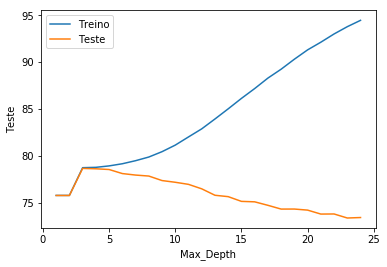

In [0]:
# importa bibliotecas para poder trabalhar com gráficos

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = 'Max_Depth', y='Treino', data = resultados)
sns.lineplot(x = 'Max_Depth', y='Teste', data = resultados)
plt.legend(['Treino','Teste'])

# Observa-se que a partir da profundidade 3 ocorre o OVERFIT, ou seja, 
# os resultados de treino continuam melhorando enquanto os de teste pioram, nao possuindo a capacidade de generalização

In [0]:
resultados.sort_values('Teste', ascending = False).head()  # ordena em ordem decrescente para descobrir os melhores testes

,Max_Depth,Treino,Teste
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Testando Hiperparâmetros - 2 Dimensões
   **Profundidade Máxima da Árvore e Número Mínimo de Elementos em uma Folha**

In [0]:
# função para retornar os resultados de treino e teste de 2 hiperparâmetros

def roda_arvore_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf)  # acrescenta o hiperparâmetro min_samples_leaf
  
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True) 
  
  resultado_treino = results['train_score'].mean() * 100  
  resultado_teste  = results['test_score'].mean() * 100
  
  print('Árvore Max_depth: %d - Min_Samples_Leaf: %.2f - Média Treino: %.2f - Média Teste: %.2f' % (max_depth, min_samples_leaf , resultado_treino, resultado_teste))
  tabela = [max_depth, min_samples_leaf , resultado_treino, resultado_teste]
  return tabela


In [0]:
# função que vai percorrer a arvore com diversos valores dos 2 hiperparâmetros e transformar os resultados em um DF

def busca():
  resultados = []  
  for max_depth in range(1, 25):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ['Max_Depth','Min_Samples_Leaf','Treino','Teste']) 
  return resultados

resultados = busca()
resultados.head()

Árvore Max_depth: 1 - Min_Samples_Leaf: 32.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 1 - Min_Samples_Leaf: 64.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 1 - Min_Samples_Leaf: 128.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 1 - Min_Samples_Leaf: 256.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 2 - Min_Samples_Leaf: 32.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 2 - Min_Samples_Leaf: 64.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 2 - Min_Samples_Leaf: 128.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 2 - Min_Samples_Leaf: 256.00 - Média Treino: 75.79 - Média Teste: 75.78
Árvore Max_depth: 3 - Min_Samples_Leaf: 32.00 - Média Treino: 78.75 - Média Teste: 78.67
Árvore Max_depth: 3 - Min_Samples_Leaf: 64.00 - Média Treino: 78.75 - Média Teste: 78.67
Árvore Max_depth: 3 - Min_Samples_Leaf: 128.00 - Média Treino: 78.75 - Média Teste: 78.67
Árvore Max_depth

,Max_Depth,Min_Samples_Leaf,Treino,Teste
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [0]:
resultados.sort_values('Teste', ascending = False).head() # ordena em ordem decrescente para descobrir os melhores testes

,Max_Depth,Min_Samples_Leaf,Treino,Teste
13,4,64,78.750993,78.672633
15,4,256,78.750993,78.672633
14,4,128,78.750993,78.672633
8,3,32,78.750993,78.672633
9,3,64,78.750993,78.672633


# Testando a Correlação

In [0]:
correlacao_resultados = resultados.corr()   # método do pandas que mostra a correlação dos dados, lembrando que correlação != de causualidade
correlacao_resultados.head()

# Existem inúmeras maneiras de visualisação dos resultados, escolher a que melhor se adequa a situação
# Através da algumas visualisações é possivel perceber que:

# quando max_depth cresce, o treino parece crescer também
# quando min_samples_leaf cresce, o treino cai
# quando max_depth sobe, o teste cai
# quando min_samples_leaf sobe, o teste sobe


# A partir dos resultados e da verificação da correlação altera-se os intervalos dos hiperparametros para tentar otimizar o estimador

,Max_Depth,Min_Samples_Leaf,Treino,Teste
Max_Depth,1.000000,0.000000,0.621516,0.015446
Min_Samples_Leaf,0.000000,1.000000,-0.335299,0.280072
Treino,0.621516,-0.335299,1.000000,0.279617
Teste,0.015446,0.280072,0.279617,1.000000


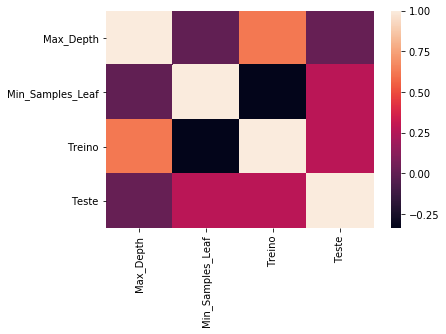

In [0]:
sns.heatmap(correlacao_resultados)   # mapa de calor da correlação

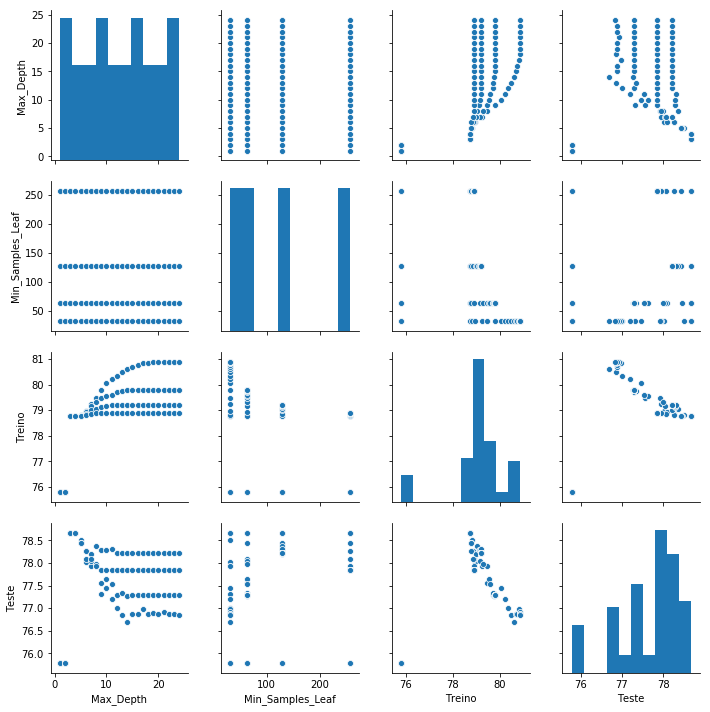

In [0]:
sns.pairplot(resultados)  # realiza o pareamento dos resultados, na diagonal estão os histogramas dos valores

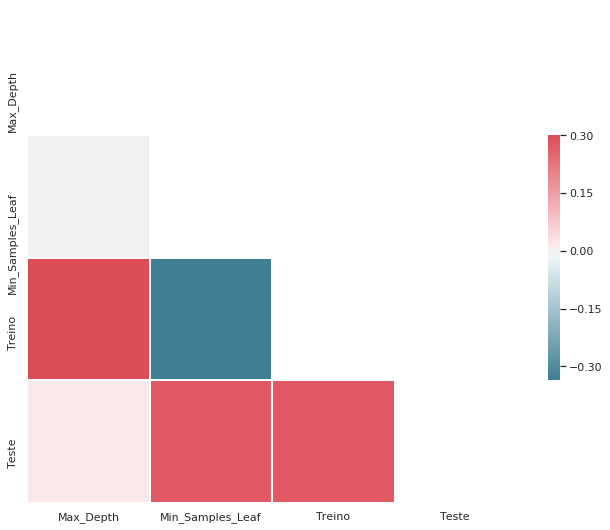

In [0]:
# Por último, gera-se outro gráfico que consta na própria documentação do Seaborn Correlations.
# Copiei e removi apenas os trechos em que os dados são gerados e atribuídos à uma variável

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlacao_resultados, dtype=np.bool)     # substituir pela variavel de correlacao_resultados
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlacao_resultados, mask=mask, cmap=cmap, vmax=.3, center=0,   # substituir pela variavel de correlacao_resultados
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Testando Hiperparâmetros - 3 Dimensões
   **Profundidade Máxima da Árvore,
   Número Mínimo de Elementos em uma Folha e 
   Número Mínimo de Elementos para Divisão**

In [0]:
# função para retornar os resultados de treino e teste de 3 hiperparâmetros

def roda_arvore_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)  # acrescenta o hiperparâmetro min_samples_split
  
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True) 
  
  tempo_treino = results['fit_time'].mean()    # extrair a média de tempo do treino
  tempo_teste = results['score_time'].mean()   # extrair a média de tempo do teste
  resultado_treino = results['train_score'].mean() * 100  
  resultado_teste  = results['test_score'].mean() * 100
  
  # print('Árvore Max_depth: %d - Min_Samples_Leaf: %.2f - Min_Samples_Split: %d - Média Treino: %.2f - Média Teste: %.2f' % (max_depth, min_samples_leaf, min_samples_split , resultado_treino, resultado_teste))
  # O print serve apenas para acompanhar enquanto roda, porém o codigo esta muito grande, não havendo necessidade para tal
  
  tabela = [max_depth, min_samples_leaf, min_samples_split, resultado_treino, resultado_teste, tempo_treino,  tempo_teste]
  return tabela


In [0]:
# função que vai percorrer a arvore com diversos valores dos 3 hiperparâmetros e transformar os resultados em um DF

def busca():
  resultados = []  
  for max_depth in range(1, 25):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ['Max_Depth','Min_Samples_Leaf','Min_Samples_Split','Treino','Teste','Tempo_Treino','Tempo_Teste']) 
  return resultados

resultados = busca()
resultados.head()

,Max_Depth,Min_Samples_Leaf,Min_Samples_Split,Treino,Teste,Tempo_Treino,Tempo_Teste
0,1,32,32,75.791169,75.784219,0.006184,0.001628
1,1,32,64,75.791169,75.784219,0.005803,0.001513
2,1,32,128,75.791169,75.784219,0.006231,0.001618
3,1,32,256,75.791169,75.784219,0.005835,0.001568
4,1,64,32,75.791169,75.784219,0.005784,0.001497


In [0]:
correlacao_resultados = resultados.corr()
correlacao_resultados.head()

,Max_Depth,Min_Samples_Leaf,Min_Samples_Split,Treino,Teste,Tempo_Treino,Tempo_Teste
Max_Depth,1.000000,0.000000,0.000000,0.609984,0.055637,0.672337,0.190696
Min_Samples_Leaf,0.000000,1.000000,0.000000,-0.276354,0.228773,-0.447306,-0.247613
Min_Samples_Split,0.000000,0.000000,1.000000,-0.100830,0.107694,-0.053861,-0.033229
Treino,0.609984,-0.276354,-0.100830,1.000000,0.395434,0.901876,0.452758
Teste,0.055637,0.228773,0.107694,0.395434,1.000000,0.099516,0.173134


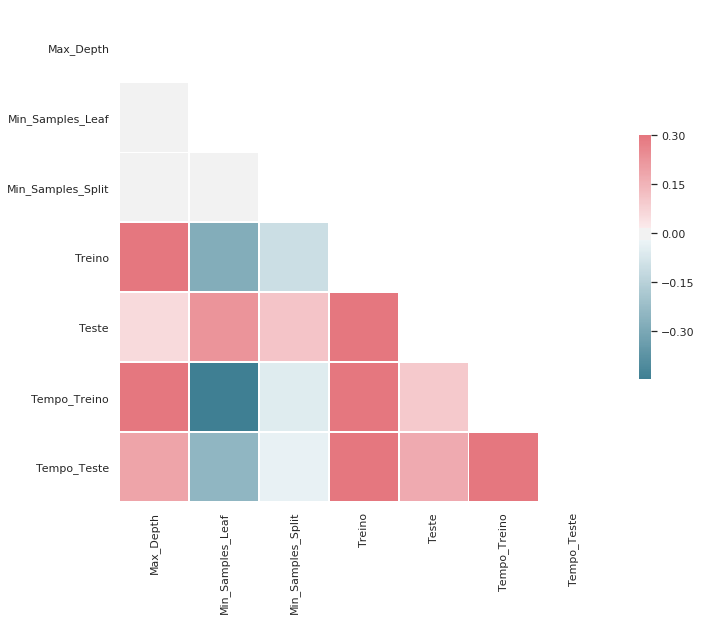

In [0]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlacao_resultados, dtype=np.bool)     # substituir pela variavel de correlacao_resultados
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlacao_resultados, mask=mask, cmap=cmap, vmax=.3, center=0,   # substituir pela variavel de correlacao_resultados
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
resultados.sort_values('Teste', ascending = False).head()

# Como tanto o tempo de treino quanto de teste são proximos uns dos outros, acabam não sendo tao relevantes neste exemplo
# Porem em situações na qual o tempo de processamento são mais elevedados, pode ser mais um critério de escolha de valores

,Max_Depth,Min_Samples_Leaf,Min_Samples_Split,Treino,Teste,Tempo_Treino,Tempo_Teste
54,4,64,128,78.750993,78.672633,0.011885,0.001818
38,3,64,128,78.750993,78.672633,0.010190,0.001747
56,4,128,32,78.750993,78.672633,0.011877,0.001775
55,4,64,256,78.750993,78.672633,0.011926,0.001834
53,4,64,64,78.750993,78.672633,0.011934,0.001803


# Busca de Hiperparâmetros com o GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV  # serve para buscar os melhores valores dos hiperparâmetros com validação cruzada

SEED = 301
np.random.seed(SEED)

# 4 dimensões
espaco_parametros = {
    'max_depth' : [3, 5],
    'min_samples_leaf' : [32,64,128],
    'min_samples_split' : [32,64,128],
    'criterion' : ['gini','entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),  
                    espaco_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)   # o gridsearch possui um método que retorna os resultados
resultados.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011150,0.001609,0.001676,0.000141,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.7868,0.011338,1
1,0.010790,0.001088,0.001655,0.000105,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.7868,0.011338,1
2,0.010008,0.000157,0.001518,0.000086,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.7868,0.011338,1
3,0.010170,0.000245,0.001688,0.000187,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.7868,0.011338,1
4,0.010286,0.000290,0.001812,0.000091,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.7868,0.011338,1


In [0]:
# métodos do gridsearchcv que retornam respectivamente os melhores valores dos hiperparâmetros e seu resultado
print(busca.best_params_)      
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.68


In [0]:
# método que retorna o melhor modelo
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
from sklearn.metrics import accuracy_score

# evitar esta abordagem pois estará sendo otimista, acaba incorrendo em um vício sobre os dados que já tínhamos visto
predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar)*100
print("A acurácia foi de %.2f" %accuracy)

A acurácia foi de 78.75


# Estimativa com Validação Cruzada Aninhada - Nested Cross Validation
 **Antes havia treinado e testado, agora vamos validar**

In [0]:
from sklearn.model_selection import cross_val_score

# scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo) 
# ocorre um erro com o GroupKFold quando usa validação cruzada aninhada, por um bug do pandas que ainda nao foi corrigido
# Logo não conseguiremos prever o resultado para novos grupos

# Então usar o KFold normal



In [0]:
from sklearn.model_selection import GridSearchCV, KFold

SEED = 301
np.random.seed(SEED)

# 4 dimensões
espaco_parametros = {
    'max_depth' : [3, 5],
    'min_samples_leaf' : [32,64,128],
    'min_samples_split' : [32,64,128],
    'criterion' : ['gini','entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),  
                    espaco_parametros,
                    cv = KFold(n_splits = 5, shuffle = True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011567,0.003208,0.002112,0.000669,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.008955,0.000085,0.001579,0.000084,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.009187,0.000408,0.001645,0.000250,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009152,0.000150,0.001641,0.000229,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008991,0.000238,0.001543,0.000102,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [0]:
# validando
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits = 5, shuffle = True)) 
scores

KeyboardInterrupt: ignored

In [0]:
def imprime_scores(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [0]:
imprime_scores(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [0]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

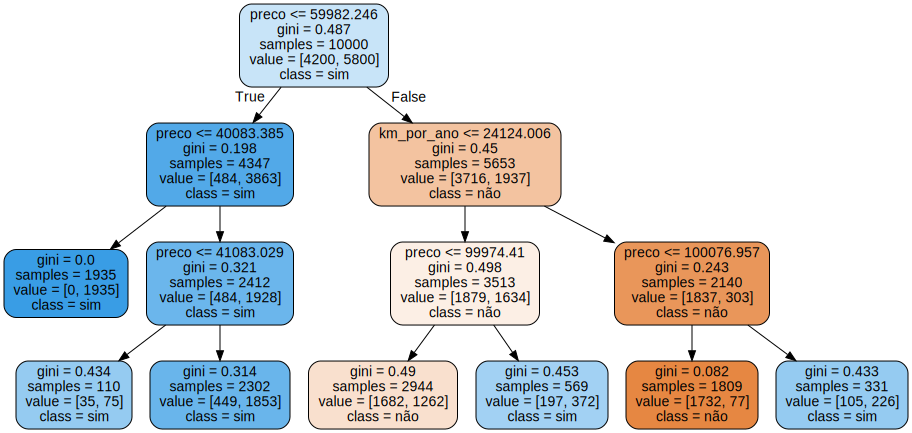

In [0]:
# imprime a arvore de decisão do melhor modelo encontrado

from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Parte 2: Otimização com Exploração Aleatória

**A diferença é que o random search (busca aleatória) procura valores aleatórios em um determinado espaço, e o grid search (busca por grade), como visto anteriormente, procura em todos os valores.**

In [0]:
from sklearn.model_selection import RandomizedSearchCV   # algoritmo de busca aleatória

SEED = 301
np.random.seed(SEED)

# 4 dimensões e 36 espaços de hiperparâmetros
espaco_parametros = {
    'max_depth' : [3, 5],
    'min_samples_leaf' : [32,64,128],
    'min_samples_split' : [32,64,128],
    'criterion' : ['gini','entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),  
                    espaco_parametros,
                    n_iter = 16, # reduziu a busca de 36 para 16
                    cv = KFold(n_splits = 5, shuffle = True),
                    random_state = SEED)   # passar o SEED para o random state

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012918,0.001807,0.001787,0.000219,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.009302,0.000122,0.001950,0.000351,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.009273,0.000249,0.001593,0.000178,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.018374,0.000078,0.001932,0.000057,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.018483,0.000080,0.002082,0.000217,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


**Validando o modelo treinado**

In [0]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits = 5, shuffle = True)) 
scores

array([0.7825, 0.783 , 0.794 , 0.781 , 0.795 ])

In [0]:
imprime_scores(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [0]:
melhor = busca.best_estimator_
melhor

# Com isso percebe-se, que com o RandomizedSearchCV explorando menos espaços consegue resultados muito próximos do GridSearch

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=64,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Customizando o Espaço de Hiperparâmetros
**Uma busca em grid precisa de pontos específicos (discretos), portanto 1, 2, ..., 10. A busca aleatória permite espaços contínuos.**

In [0]:
from scipy.stats import randint  

SEED = 301
np.random.seed(SEED)

# 4 dimensões e 129.024 espaços de hiperparâmetros
espaco_parametros = {
    'max_depth' : [3, 5, 10, 15, 20, 30, None],
    'min_samples_leaf' : randint(32, 128),   # chama 96 numeros aleatorios, entre 32 e 128
    'min_samples_split' : randint(32, 128),
    'criterion' : ['gini','entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),  
                    espaco_parametros,
                    n_iter = 16, # reduziu a busca de 129.024 para 16
                    cv = KFold(n_splits = 5, shuffle = True),
                    random_state = SEED)  

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014174,0.001868,0.001734,0.000040,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.015807,0.000382,0.001878,0.000057,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.015155,0.000818,0.001944,0.000203,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.018559,0.000918,0.001970,0.000121,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.014556,0.000413,0.001846,0.000016,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [0]:
# validação cruzada aninhada

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

# Realizamos a busca muito mais rápida do que se fosse realizar a busca em todos os espaços de parâmetros

Accuracy médio 78.70
Intervalo [76.85, 80.55]
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [0]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score', ascending = False)  # ordenar a coluna mean_test_score de forma decrescente
for indice, linha in resultados_ordenados_pela_media.iterrows():  #itrrows é um gerador de iteração que devolve dois elementos em cada uma das linhas: o índice e a linha
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))  
  # printa as médias de cada um dos 16 resultados, o desvio padrão e os seus respectivos hiperparâmetros

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +- (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +- (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +- (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +- (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +- (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +- (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +- (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +- (0.014) {'criterion': 'entropy', 

# Aumentando a Quantidade de Espaços Aleatórios Buscados

In [0]:
SEED = 301
np.random.seed(SEED)

# 4 dimensões e 129.024 espaços de hiperparâmetros
espaco_parametros = {
    'max_depth' : [3, 5, 10, 15, 20, 30, None],
    'min_samples_leaf' : randint(32, 128),   
    'min_samples_split' : randint(32, 128),
    'criterion' : ['gini','entropy']
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),  
                    espaco_parametros,
                    n_iter = 64, # Explorando 4 vezes mais o espaço, em relação a busca passada
                    cv = KFold(n_splits = 5, shuffle = True),
                    random_state = SEED)  

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013643,0.000484,0.001688,0.000065,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.015845,0.000382,0.001732,0.000051,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,46
2,0.014698,0.000454,0.001862,0.000242,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,27
3,0.019006,0.000934,0.002113,0.000218,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,64
4,0.014671,0.000402,0.001921,0.000043,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,26


In [0]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score', ascending = False) 
for indice, linha in resultados_ordenados_pela_media.iterrows(): 
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))  
  
# Mostra as 64 buscas, sendo a primeira linha o melhor resultado

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +- (0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +- (0.024) {'criterion': 'gini', 'max_de

In [0]:
# validação cruzada aninhada

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

# Percebe-se que mesmmo explorando 4 vezes mais espaços, não houve muita alteração no resultado

Accuracy médio 78.66
Intervalo [76.79, 80.53]
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


# Comparando o GridSearchCV com o RandomizedSearchCV

**GridSearchCV**

In [0]:
from sklearn.ensemble import RandomForestClassifier  # um outro algoritmo de árvore de decisão, onde ao invés de tentar uma única árvore, tenta diversas árvores
import time


SEED = 301
np.random.seed(SEED)

# 6 dimensões e 144 espaços de hiperparâmetros
espaco_parametros = {
    'n_estimators' : [10,100],    # a quantidade de estimadores que serão treinados
    'bootstrap': [True,False],    # permite definir se um mesmo elemento pode fazer parte de diferentes amostras
    'max_depth' : [3, 5],  
    'min_samples_leaf' : [32,64,128],
    'min_samples_split' : [32,64,128],
    'criterion' : ['gini','entropy']
}

tic = time.time() # mede o tempo do inicio

busca = GridSearchCV(RandomForestClassifier(),  
                    espaco_parametros,
                    cv = KFold(n_splits = 5, shuffle = True))  
busca.fit(x_azar, y_azar)

tac = time.time() # mede o tempo do fim

tempo_decorrido = tac - tic 
print("Tempo %.2f segundos" % tempo_decorrido)


resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

Tempo 0.00 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030816,0.002452,0.004000,0.000198,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.272368,0.005303,0.021567,0.002119,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.030427,0.000670,0.003796,0.000032,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.266640,0.003311,0.020174,0.000551,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.029630,0.001070,0.003796,0.000018,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [0]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score', ascending = False) 
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():   # apenas os 5 primeiros
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))  

0.780 +- (0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +- (0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +- (0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +- (0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +- (0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


**Vai demorar tanto que não consegue rodar no Colab, teria que importar pra maquina**

In [0]:
#tic = time.time()
#scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
#tac = time.time()
#tempo_decorrido = tac - tic
#print("Tempo %.2f segundos" % tempo_passado)

#imprime_scores(scores)
#melhor = busca.best_estimator_
#print(melhor)

**RandomizedSearchCV**

In [0]:
SEED = 301
np.random.seed(SEED)

# 6 dimensões e 144 espaços de hiperparâmetros
espaco_parametros = {
    'n_estimators' : [10,100],    # a quantidade de estimadores que serão treinados
    'bootstrap': [True,False],    # permite definir se um mesmo elemento pode fazer parte de diferentes amostras
    'max_depth' : [3, 5],  
    'min_samples_leaf' : [32,64,128],
    'min_samples_split' : [32,64,128],
    'criterion' : ['gini','entropy']
}

tic = time.time() # mede o tempo do inicio

busca = RandomizedSearchCV(RandomForestClassifier(),  # mudar o grid pelo random
                    espaco_parametros,
                     n_iter = 20,     # realizar uma busca em 20 espaços
                    cv = KFold(n_splits = 5, shuffle = True))  
busca.fit(x_azar, y_azar)

tac = time.time() # mede o tempo do fim

tempo_decorrido = tac - tic 
print("Tempo %.2f segundos" % tempo_decorrido)


resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

Tempo 27.62 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.368119,0.010177,0.019992,0.000241,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7740,0.7925,0.7775,0.7560,0.7742,0.011724,10
1,0.051924,0.002319,0.004075,0.000085,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.750,0.7785,0.7820,0.7785,0.7645,0.7707,0.011969,13
2,0.525789,0.004688,0.022958,0.000408,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.771,0.7745,0.7930,0.7785,0.7585,0.7751,0.011178,6
3,0.029680,0.001017,0.003763,0.000100,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.750,0.7600,0.7450,0.7390,0.7520,0.7492,0.007026,20
4,0.057062,0.003444,0.003884,0.000042,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.771,0.7740,0.7635,0.7370,0.7585,0.7608,0.013094,18


In [0]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score', ascending = False) 
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():   # apenas os 5 primeiros
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))  
  
# Em um tempo bem menor consegue-se resultados próximos ao do GridSearchCV

0.776 +- (0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +- (0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +- (0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.775 +- (0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +- (0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [0]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_scores(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 110.93 segundos
Accuracy médio 77.59
Intervalo [76.47, 78.71]
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


**Aumentando o Espaço de Hiperparâmetros e a Busca Aleatória**

In [0]:
SEED = 301
np.random.seed(SEED)

# 6 dimensões e aumentou para 10.274.628 combinações
espaco_parametros = {
    'n_estimators' : randint(10, 101),    
    'bootstrap': [True,False],    
    'max_depth' : randint(3, 6),  
    'min_samples_leaf' : randint(32, 129),
    'min_samples_split' : randint(32, 129),
    'criterion' : ['gini','entropy']
}

tic = time.time() # mede o tempo do inicio

busca = RandomizedSearchCV(RandomForestClassifier(),  
                    espaco_parametros,
                     n_iter = 80,     # aumentou a busca para 80 iterações em cima das 10 milhões de espaços possíveis
                    cv = KFold(n_splits = 5, shuffle = True))  
busca.fit(x_azar, y_azar)

tac = time.time() # mede o tempo do fim

tempo_decorrido = tac - tic 
print("Tempo %.2f segundos" % tempo_decorrido)


resultados = pd.DataFrame(busca.cv_results_)  
resultados.head()

Tempo 96.05 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.316732,0.004936,0.018631,0.000377,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.214421,0.002946,0.016916,0.000302,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.205138,0.000960,0.015994,0.000196,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.133564,0.002226,0.011189,0.000188,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.213426,0.002358,0.015472,0.000208,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,28


In [0]:
resultados_ordenados_pela_media = resultados.sort_values('mean_test_score', ascending = False) 
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():   # apenas os 5 primeiros
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))  
  
# Mesmo nesse espaço enorme de mais de 10 milhões de combinações, não tivemos uma variabilidade muito grande de resultados.

0.779 +- (0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +- (0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +- (0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.777 +- (0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +- (0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


# Otimização sem validação cruzada (treino, teste e validação)

In [0]:
# separa antecipadamente 20% dos dados para validação
from sklearn.model_selection import train_test_split


SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size = 0.2, shuffle = True, stratify = y_azar) 
print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit  
# o StratifiedShuffleSplit irá aleatorizar a ordem dos dados e quebrá-los de acordo com a estratificação dos dados que passarmos para ele

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)  # 25 % pra teste, que equivale a 20% do total de dados (treino,teste,validação)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,  # realizar apenas 5 iterações aleatórias
                    cv = split)  # trocar o KFold pelos parâmetros do StratifiedShuffleSplit 
busca.fit(x_treino_teste, y_treino_teste)  # utiliza os 80% restante dos dados (pois 20% haviam sidos retirados para validação)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.13 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.254687,0.0,0.018560,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7745,0.7745,0.0,2
1,0.182880,0.0,0.017763,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7735,0.0,5
2,0.173362,0.0,0.016132,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,2
3,0.118115,0.0,0.011161,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7750,0.7750,0.0,1
4,0.172199,0.0,0.015826,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,2


In [0]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)   # substitui pelos dados de validação, que haviam sidos separados no início
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)
scores

# O resultado é apenas um valor - como só tivemos um teste e uma validação, remove-se a impressão da média e do intervalo

# O cross validation é um processo bastante interessante e prático. 
# Porém, quando existem motivos para não utilizarmos o cross validation, devemos nos atentar a alguns detalhes importantes 
# por exemplo, à perda do intervalo de resultados.

Tempo 0.24 segundos


array([0.746])